## 2. Ill-conditioned Quadratic Function

This notebook runs the experiment for the second benchmark problem: an ill-conditioned quadratic function $f(x) = \frac{1}{2}x^{T}Qx$ with $cond(Q) \ge 50$ and $dim(x) \ge 10$.
The goal is to report the number of iterations to reach $f(x) < 1e-6$.

### Cell 1: Imports

In [1]:
import torch  # PyTorch for optimization
import torch.optim as optim  # Built-in optimizers
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
from collections import defaultdict  # For results storage

### Cell 2: Helper Function - Create Quadratic Function

In [2]:
def create_quadratic_fn(n_dim, cond_num):  # Generate ill-conditioned Q matrix
    eigenvalues = np.linspace(1, cond_num, n_dim)  # Eigenvalue range
    A = np.random.rand(n_dim, n_dim)  # Random matrix
    P, _ = np.linalg.qr(A)  # Orthogonalization
    P = torch.tensor(P, dtype=torch.float32)
    D = torch.diag(torch.tensor(eigenvalues, dtype=torch.float32))  # Diagonal matrix
    Q = P @ D @ P.T  # Symmetric positive-definite matrix
    def f(x): return 0.5 * x.T @ Q @ x  # Quadratic function
    return f

### Cell 3: Helper Function - Run Optimization

In [3]:
def run_function_optimization(func, start_params, optimizer_class, optimizer_params, target_loss, max_iter=40000):  # Run optimization
    params = start_params.clone().detach().requires_grad_(True)
    optimizer = optimizer_class([params], **optimizer_params)
    loss_history = []
    for i in range(max_iter):
        optimizer.zero_grad()  # Clear grads
        loss = func(params)  # Compute loss
        if loss.item() < target_loss:  # Stop if below threshold
            loss_history.append(loss.item())
            return i, loss_history
        loss.backward()  # Compute gradient
        optimizer.step()  # Update params
        loss_history.append(loss.item())
    return max_iter, loss_history

### Cell 4: Novel Optimizer

In [4]:
class YourNovelOptimizer(optim.Optimizer):  # Custom optimizer class
    def __init__(self, params, lr=0.01, **kwargs):  # Init
        defaults = dict(lr=lr, **kwargs)
        super(YourNovelOptimizer, self).__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['step'] = 0

    @torch.no_grad()
    def step(self, closure=None):  # One optimization step
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data  # Gradient
                self.state[p]['step'] += 1
                p.data.add_(grad, alpha=-lr)  # SGD-like update
        return loss

### Cell 5: Run Experiment

In [5]:
N_DIM, COND_NUM, TARGET_LOSS, N_RUNS, MAX_ITER = 10, 50, 1e-6, 5, 40000  # Config
optimizers_to_test = {  # Optimizers to test
    'SGD_Momentum': (optim.SGD, {'lr': 0.01, 'momentum': 0.9}),
    'Adam': (optim.Adam, {'lr': 0.001, 'betas': (0.9, 0.999)}),
    'RMSprop': (optim.RMSprop, {'lr': 0.01}),
    'YourOptimizer': (YourNovelOptimizer, {'lr': 0.01})
}
results = defaultdict(lambda: defaultdict(list))  # Store results
print(f'Running Ill-Conditioned Quadratic (Dim={N_DIM}, Cond={COND_NUM})')
for run in range(N_RUNS):
    print(f'--- Run {run+1}/{N_RUNS} ---')
    func = create_quadratic_fn(N_DIM, COND_NUM)  # Create function
    start_params = torch.randn(N_DIM, dtype=torch.float32) * 10  # Init
    for opt_name, (opt_class, opt_params) in optimizers_to_test.items():
        iters, loss_hist = run_function_optimization(func, start_params, opt_class, opt_params, TARGET_LOSS, MAX_ITER)
        results[opt_name]['iterations'].append(iters)
        results[opt_name]['loss_curves'].append(loss_hist)
        print(f'{opt_name} converged in {iters} iterations' if iters < MAX_ITER else f'{opt_name} failed')
print('--- All runs complete ---')

Running Ill-Conditioned Quadratic (Dim=10, Cond=50)
--- Run 1/5 ---


C:\Users\Parthiv\AppData\Local\Temp\ipykernel_17624\3317975734.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  def f(x): return 0.5 * x.T @ Q @ x  # Quadratic function


SGD_Momentum converged in 209 iterations
Adam converged in 23325 iterations
RMSprop failed
YourOptimizer converged in 699 iterations
--- Run 2/5 ---
SGD_Momentum converged in 209 iterations
Adam converged in 28393 iterations
RMSprop failed
YourOptimizer converged in 814 iterations
--- Run 3/5 ---
SGD_Momentum converged in 209 iterations
Adam converged in 33900 iterations
RMSprop failed
YourOptimizer converged in 924 iterations
--- Run 4/5 ---
SGD_Momentum converged in 209 iterations
Adam converged in 31791 iterations
RMSprop failed
YourOptimizer converged in 510 iterations
--- Run 5/5 ---
SGD_Momentum converged in 201 iterations
Adam converged in 19721 iterations
RMSprop failed
YourOptimizer converged in 821 iterations
--- All runs complete ---


### Cell 6: Report Results (Table)

In [6]:
print(f'\n{"="*20} FINAL RESULTS {"="*20}')
print(f'Benchmark 2: Ill-Conditioned Quadratic (Target Loss: {TARGET_LOSS})')
print(f'Results over {N_RUNS} runs:\n')
print(f'{'Optimizer':<15} | {'Iterations (Mean ± Std)':<25}')
print('-'*45)
for opt_name in optimizers_to_test.keys():
    iters = np.array(results[opt_name]['iterations'])
    mean_iters, std_iters = np.mean(iters), np.std(iters)
    if mean_iters >= MAX_ITER:
        print(f'{opt_name:<15} | > {MAX_ITER} (Failed)')
    else:
        print(f'{opt_name:<15} | {mean_iters:,.1f} ± {std_iters:,.1f}')


==================== FINAL RESULTS ====================
Benchmark 2: Ill-Conditioned Quadratic (Target Loss: 1e-06)
Results over 5 runs:

Optimizer       | Iterations (Mean ± Std)  
---------------------------------------------
SGD_Momentum    | 207.4 ± 3.2
Adam            | 27,426.0 ± 5,255.2
RMSprop         | > 40000 (Failed)
YourOptimizer   | 753.6 ± 141.1


### Cell 7: Plot Convergence Curves

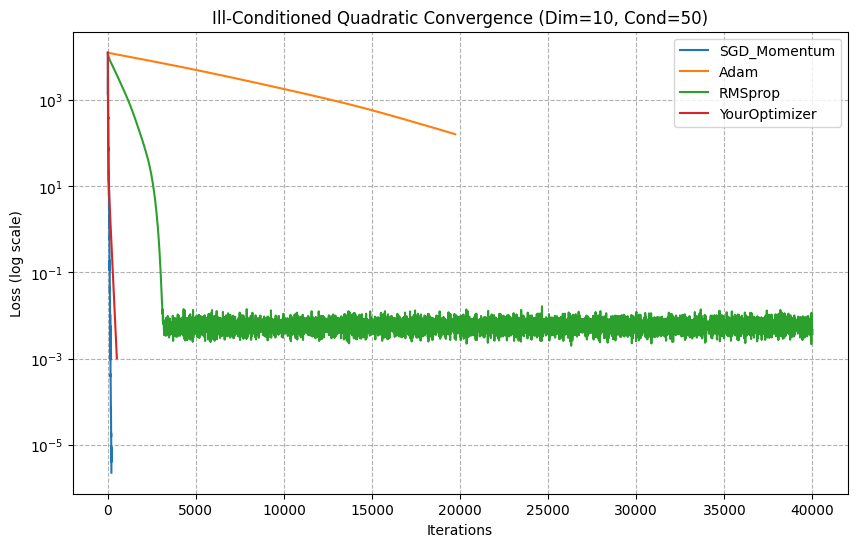

In [7]:
plt.figure(figsize=(10,6))  # Create plot
plt.title(f'Ill-Conditioned Quadratic Convergence (Dim={N_DIM}, Cond={COND_NUM})')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
for opt_name in optimizers_to_test.keys():  # Plot each optimizer
    curves = results[opt_name]['loss_curves']
    min_len = min(len(c) for c in curves)
    avg_curve = np.mean([c[:min_len] for c in curves], axis=0)
    plt.plot(avg_curve, label=opt_name)
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()